Il codice installa e configura la libreria spaCy per l'elaborazione del linguaggio naturale in italiano

In [12]:
!pip install -U spacy
!python -m spacy download it_core_news_sm
!pip install ydata-profiling matplotlib seaborn
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
nlp = spacy.load("it_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 68.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Definisce una funzione che conta il numero di parole (token) in una frase utilizzando spaCy.

In [13]:
def conta_token(frase):
    doc = nlp(frase)
    tokens = [(token.text, token.pos_) for token in doc]
    return len(tokens)

Il codice crea un dataset di frasi con sinonimi e ridondanze, lo memorizza in un DataFrame di pandas, e calcola il numero totale di token per ogni frase usando la funzione conta_token().

- In breve, fa tre cose principali:

Crea una lista di frasi, includendo:
Frasi su Roma e l'Italia.
Frasi con sinonimi di "auto".
Frasi duplicate o quasi identiche.
Frasi varie per arricchire il dataset.

Converte il dataset in un DataFrame pandas.

Conta i token in ogni frase e somma il totale.

In [14]:
# Esempio di dataset con frasi ridondanti o sinonimi
dataset = [
    # Frasi su Roma / Italia già note al KG (verranno rimosse)
    "La capitale d'Italia è Roma.",
    "Roma si trova nella regione Lazio.",
    "L'Italia ha come capitale Roma da molti anni.",

    # Frasi semisimili/extra su Roma (per vedere se vengono considerate ridondanti)
    "La città di Roma è situata nel centro Italia.",
    "Il Colosseo si trova a Roma.",

    # Frasi con sinonimi di 'auto'
    "Mi piace guidare la mia auto.",
    "La mia macchina è molto veloce.",
    "Ho acquistato una nuova automobile.",
    "Vorrei comprare un'automobile di lusso.",
    "La mia auto è parcheggiata qui.",

    # Duplicate esatte o quasi esatte
    "Il Duomo di Milano è un famoso monumento.",
    "Il Duomo di Milano è un famoso monumento!",  # Con esclamazione
    "Il Duomo di Milano è un noto monumento storico.",  # Sinonimo "noto"
    "Amo visitare il Duomo di Milano.",

    # Altre frasi su diversi soggetti (per colorare il dataset)
    "La casa di Maria è molto accogliente.",
    "La dimora di Maria è molto accogliente.",   # Sinonimo "dimora" -> "casa"
    "Il gatto di Luca dorme sul divano.",
    "Milano si trova in Lombardia.",
    "Milano e Roma sono due grandi città italiane.",
    "Guido spesso la mia macchina in autostrada."
]
dataset_originale = dataset.copy()

df = pd.DataFrame(dataset, columns=['testo'])

print("=== CORPUS INIZIALE ===")
display(df)

# Calcoliamo il numero totale di token prima di qualsiasi elaborazione
df['n_token_iniziali'] = df['testo'].apply(conta_token)
print("Numero totale di token nel corpus INIZIALE:",
      df['n_token_iniziali'].sum())


=== CORPUS INIZIALE ===


,testo
0,La capitale d'Italia è Roma.
1,Roma si trova nella regione Lazio.
2,L'Italia ha come capitale Roma da molti anni.
3,La città di Roma è situata nel centro Italia.
4,Il Colosseo si trova a Roma.
5,Mi piace guidare la mia auto.
6,La mia macchina è molto veloce.
7,Ho acquistato una nuova automobile.
8,Vorrei comprare un'automobile di lusso.
9,La mia auto è parcheggiata qui.


Numero totale di token nel corpus INIZIALE: 157


Il codice filtra e rimuove frasi già presenti in un Knowledge Graph (KG) semplificato.

- In breve, fa quattro cose:

Definisce un piccolo Knowledge Graph con coppie di soggetto-relazione-oggetto.

Verifica se una frase contiene informazioni presenti nel KG.

Rimuove frasi già preseniti

Conta i token nel corpus rimanente dopo la rimozione.

In [15]:
# Esempio di triple del KG
kg_mock = {
    ("Italia", "capitale", "Roma"),
    ("Roma", "si_trova_in", "Lazio"),
    ("Colosseo", "localizzato_in", "Roma")
}

def contiene_info_kg(testo, kg):
    """
    Se il testo contiene soggetto e oggetto di una tripletta,
    assumiamo che la frase sia presente nel KG.
    """
    t_low = testo.lower()
    for (soggetto, relazione, oggetto) in kg:
        if soggetto.lower() in t_low and oggetto.lower() in t_low:
            return True
    return False

df["presente_in_kg"] = df["testo"].apply(lambda x: contiene_info_kg(x, kg_mock))

df_in_kg = df[df["presente_in_kg"] == True].copy()
df_fuori_kg = df[df["presente_in_kg"] == False].copy()

print("=== FRASI PRESENTI NEL KG (RIMOSSE DAL CORPUS) ===")
display(df_in_kg[["testo"]])

print("\n=== CORPUS RESTANTE DOPO RIMOZIONE FRASI GIA' NEL KG ===")
display(df_fuori_kg[["testo"]])

# Calcoliamo i token residui
df_fuori_kg["n_token_fuori_kg"] = df_fuori_kg["testo"].apply(conta_token)
print("\nNumero totale di token DOPO rimozione frasi presenti nel KG:",
      df_fuori_kg['n_token_fuori_kg'].sum())


=== FRASI PRESENTI NEL KG (RIMOSSE DAL CORPUS) ===


,testo
0,La capitale d'Italia è Roma.
1,Roma si trova nella regione Lazio.
2,L'Italia ha come capitale Roma da molti anni.
3,La città di Roma è situata nel centro Italia.
4,Il Colosseo si trova a Roma.
18,Milano e Roma sono due grandi città italiane.



=== CORPUS RESTANTE DOPO RIMOZIONE FRASI GIA' NEL KG ===


,testo
5,Mi piace guidare la mia auto.
6,La mia macchina è molto veloce.
7,Ho acquistato una nuova automobile.
8,Vorrei comprare un'automobile di lusso.
9,La mia auto è parcheggiata qui.
10,Il Duomo di Milano è un famoso monumento.
11,Il Duomo di Milano è un famoso monumento!
12,Il Duomo di Milano è un noto monumento storico.
13,Amo visitare il Duomo di Milano.
14,La casa di Maria è molto accogliente.



Numero totale di token DOPO rimozione frasi presenti nel KG: 107


Sostituisce sinonimi (macchina → auto, dimora → casa) con la funzione unifica_sinonimi_babelnet().

Elimina frasi duplicate (ignorando punteggiatura e maiuscole) con rimuovi_duplicati_conceptnet().

Conta i token nel dataset pulito dopo queste trasformazioni.

In [16]:
def unifica_sinonimi_babelnet(frase):
    """
    Mock: sostituiamo 'macchina', 'automobile' con 'auto',
          e 'dimora' con 'casa'.
    """

    tokens = frase.split()
    tokens_unificati = []
    sinonimi_auto = ["macchina", "automobile", "automobile.", "macchina.", "automobile,", "macchina,"]
    sinonimo_dimora = ["dimora", "dimora.", "dimora,", "Dimora", "Dimora.", "Dimora,"]

    for tok in tokens:
        tok_lower = tok.lower().rstrip(".,!?;:")

        if tok_lower in sinonimi_auto:
            tok_clean = "auto"
        elif tok_lower in sinonimo_dimora:
            tok_clean = "casa"
        else:
            tok_clean = tok
        tokens_unificati.append(tok_clean)

    # Ricostruisco la frase
    frase_unificata = " ".join(tokens_unificati)
    return frase_unificata

def rimuovi_duplicati_conceptnet(lista_frasi):
    """
    Mock: consideriamo due frasi duplicate se, dopo rimozione punteggiatura
    e passaggio a minuscolo, risultano identiche.
    """
    viste = set()
    frasi_finali = []

    def normalizza_per_conceptnet(frase):

        norm = frase.lower()
        for c in ".,!?:;":
            norm = norm.replace(c, "")
        norm = norm.strip()
        return norm

    for f in lista_frasi:
        norm = normalizza_per_conceptnet(f)
        if norm not in viste:
            viste.add(norm)
            frasi_finali.append(f)
        else:
            # Se è già vista, la consideriamo duplicata
            pass
    return frasi_finali

# 4.1) Unifichiamo i sinonimi con la "simulazione" di BabelNet
df_fuori_kg["testo_babelnet"] = df_fuori_kg["testo"].apply(unifica_sinonimi_babelnet)

# 4.2) Ora rimuoviamo i duplicati con la "simulazione" di ConceptNet
lista_testo_babelnet = df_fuori_kg["testo_babelnet"].tolist()
testi_finali = rimuovi_duplicati_conceptnet(lista_testo_babelnet)

df_finale_post_bn_cc = pd.DataFrame(testi_finali, columns=["testo"])
df_finale_post_bn_cc["n_token"] = df_finale_post_bn_cc["testo"].apply(conta_token)

print("=== CORPUS DOPO UNIFICAZIONE SINONIMI (BABELNET) E RIMOZIONE DUPLICATI (CONCEPTNET) ===")
display(df_finale_post_bn_cc)

print("\nNumero totale di token DOPO unificazione e rimozione duplicati:",
      df_finale_post_bn_cc["n_token"].sum())


=== CORPUS DOPO UNIFICAZIONE SINONIMI (BABELNET) E RIMOZIONE DUPLICATI (CONCEPTNET) ===


,testo,n_token
0,Mi piace guidare la mia auto.,7
1,La mia auto è molto veloce.,7
2,Ho acquistato una nuova auto,5
3,Vorrei comprare un'automobile di lusso.,7
4,La mia auto è parcheggiata qui.,7
5,Il Duomo di Milano è un famoso monumento.,9
6,Il Duomo di Milano è un noto monumento storico.,10
7,Amo visitare il Duomo di Milano.,7
8,La casa di Maria è molto accogliente.,8
9,Il gatto di Luca dorme sul divano.,8



Numero totale di token DOPO unificazione e rimozione duplicati: 89


Trasforma triple del KG in frasi leggibili (es. "Italia ha come capitale Roma.").

Aggiunge le frasi sintetiche al corpus pulito.

Calcola il numero totale di token nel corpus finale.

In [17]:
def genera_frase_sintetica_da_kg(tripla):
    """
    Generiamo una frase in modo deterministico (niente random).
    Esempio: ("Italia", "capitale", "Roma") -> "Italia ha come capitale Roma."
    """
    soggetto, relazione, oggetto = tripla

    rel_italiano = {
        "capitale": "ha come capitale",
        "si_trova_in": "è situata nella regione",
        "localizzato_in": "è localizzato/a in"
    }

    if relazione in rel_italiano:
        rel_testo = rel_italiano[relazione]
    else:
        rel_testo = relazione

    frase = f"{soggetto} {rel_testo} {oggetto}."
    return frase

# Generiamo frasi sintetiche per ogni tripletta
frasi_sintetiche = [genera_frase_sintetica_da_kg(t) for t in kg_mock]

# Creiamo un DataFrame e conteggiamo i token
df_sintetiche = pd.DataFrame(frasi_sintetiche, columns=["testo_sintetico"])
df_sintetiche["n_token_sint"] = df_sintetiche["testo_sintetico"].apply(conta_token)

print("=== FRASI SINTETICHE GENERATE DAL KG ===")
display(df_sintetiche)

# Concateniamo le frasi sintetiche al corpus finale
df_sintetiche_renamed = df_sintetiche.rename(columns={"testo_sintetico": "testo"})[["testo"]]
df_sintetiche_renamed["n_token"] = df_sintetiche_renamed["testo"].apply(conta_token)

df_corpus_finale = pd.concat([
    df_finale_post_bn_cc[["testo", "n_token"]],
    df_sintetiche_renamed[["testo", "n_token"]]
], ignore_index=True)

print("\n=== CORPUS FINALE (post-KG + frasi sintetiche) ===")
display(df_corpus_finale)

# Confronto finale sul numero di token
token_finali = df_corpus_finale["n_token"].sum()
print("\nNumero totale di token del CORPUS FINALE:", token_finali)


=== FRASI SINTETICHE GENERATE DAL KG ===


,testo_sintetico,n_token_sint
0,Roma è situata nella regione Lazio.,7
1,Italia ha come capitale Roma.,6
2,Colosseo è localizzato/a in Roma.,8



=== CORPUS FINALE (post-KG + frasi sintetiche) ===


,testo,n_token
0,Mi piace guidare la mia auto.,7
1,La mia auto è molto veloce.,7
2,Ho acquistato una nuova auto,5
3,Vorrei comprare un'automobile di lusso.,7
4,La mia auto è parcheggiata qui.,7
5,Il Duomo di Milano è un famoso monumento.,9
6,Il Duomo di Milano è un noto monumento storico.,10
7,Amo visitare il Duomo di Milano.,7
8,La casa di Maria è molto accogliente.,8
9,Il gatto di Luca dorme sul divano.,8



Numero totale di token del CORPUS FINALE: 110



Confronto tra il numero di token prima e dopo la pulizia del dataset.

In [18]:
token_iniziali = df['n_token_iniziali'].sum()
token_finali = df_corpus_finale['n_token'].sum()

print("=== CONFRONTO TOKEN ===")
print(f"Token totali iniziali: {token_iniziali}")
print(f"Token totali finali:   {token_finali}")
print("Differenza (iniziali - finali):", token_iniziali - token_finali)


=== CONFRONTO TOKEN ===
Token totali iniziali: 157
Token totali finali:   110
Differenza (iniziali - finali): 47


Visualizza la differenza tra i due dataset utilizzando un grafico a barre e un istogramma della distribuzione della lunghezza delle frasi (numero di token).

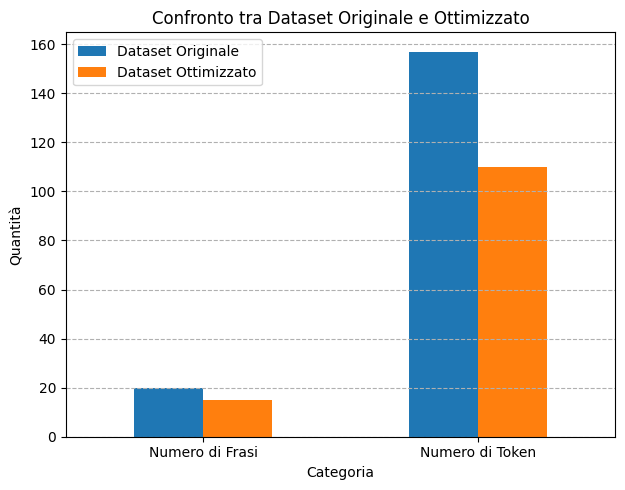

In [19]:
# Dataset ottimizzato
dataset_ottimizzato = [
    "La capitale d'Italia è Roma.",
    "Roma si trova nel Lazio.",
    "Il Colosseo è a Roma.",
    "Mi piace guidare la mia auto.",
    "Amo visitare il Duomo di Milano."
]

# Convertiamo in DataFrame
df_originale = df.copy()
df_ottimizzato = df_corpus_finale.copy()


# Aggiungiamo conteggi di token per ogni frase
df_originale['token_count'] = df_originale['testo'].apply(conta_token)
df_ottimizzato['token_count'] = df_ottimizzato['testo'].apply(conta_token)

# Calcoliamo il numero totale di frasi e token
num_frasi_originale = len(df_originale)
num_frasi_ottimizzato = len(df_ottimizzato)

num_token_originale = df_originale['token_count'].sum()
num_token_ottimizzato = df_ottimizzato['token_count'].sum()

# Creiamo un DataFrame per visualizzare il confronto
df_comparativo = pd.DataFrame({
    "Categoria": ["Numero di Frasi", "Numero di Token"],
    "Dataset Originale": [num_frasi_originale, num_token_originale],
    "Dataset Ottimizzato": [num_frasi_ottimizzato, num_token_ottimizzato]
})

# Creiamo i grafici
plt.figure(figsize=(12, 5))

#  Grafico
plt.subplot(1, 2, 1)
df_comparativo.set_index("Categoria").plot(kind='bar', ax=plt.gca(), rot=0)
plt.title("Confronto tra Dataset Originale e Ottimizzato")
plt.ylabel("Quantità")
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()
